In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sat Jan 27 11:26:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = True
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-7_ze2zq/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 9473, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

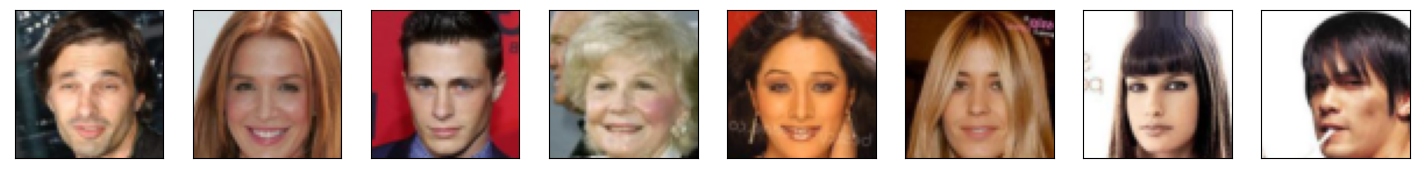

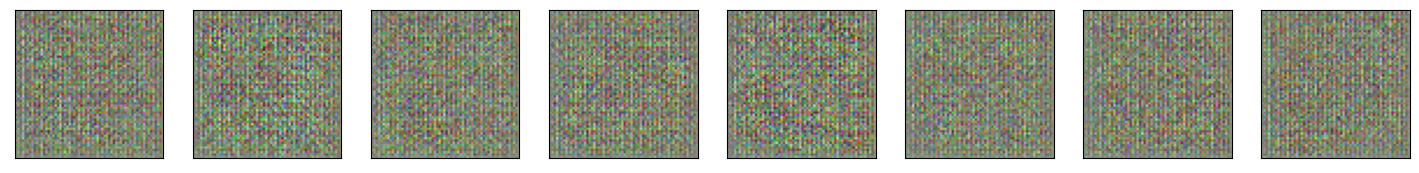

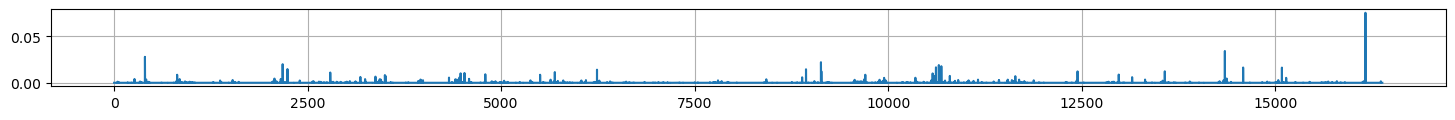

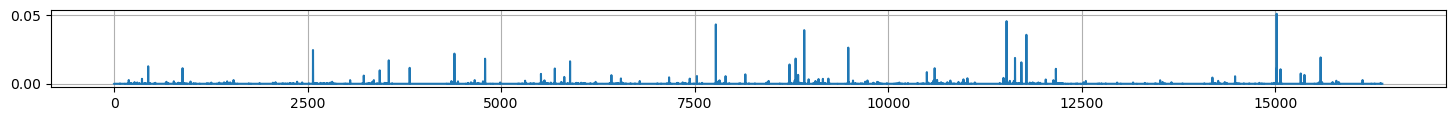

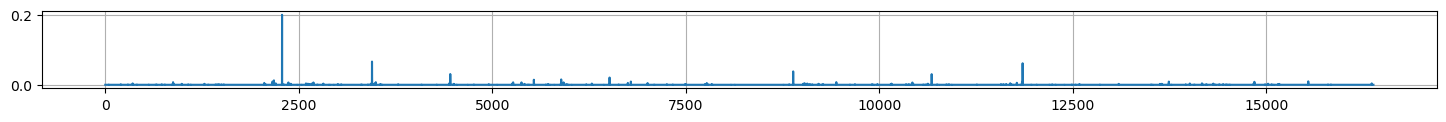

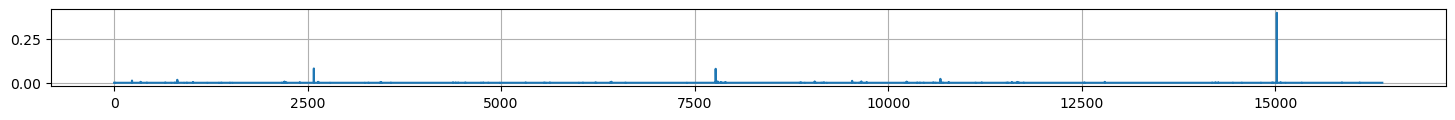

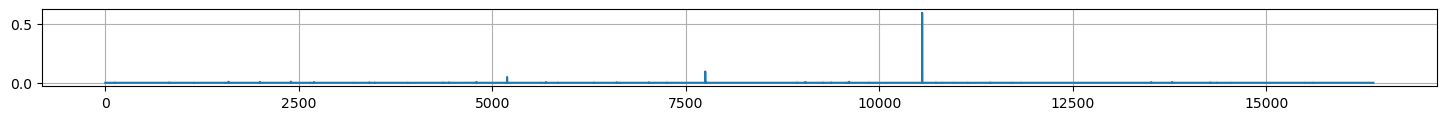

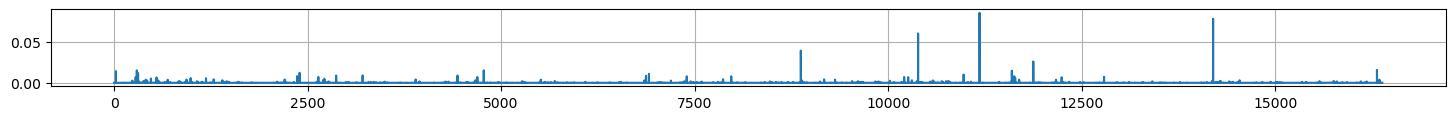

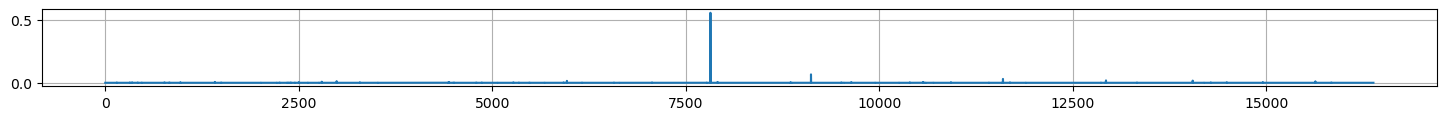

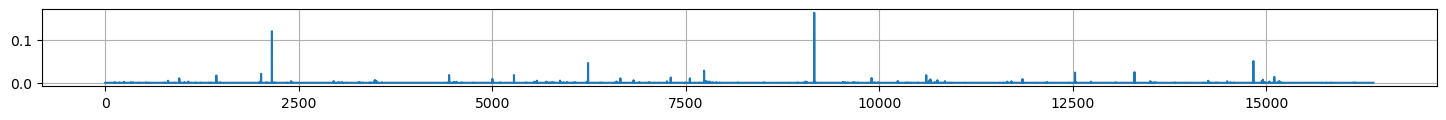

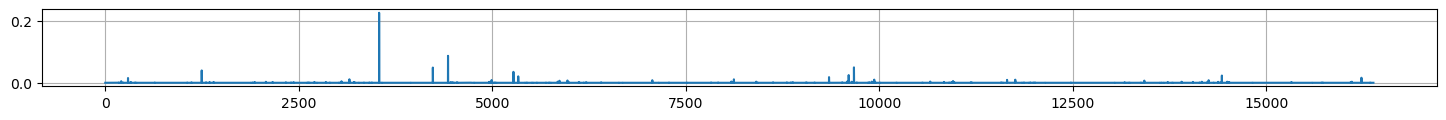

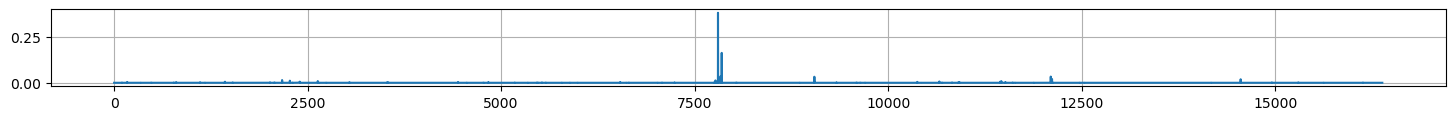

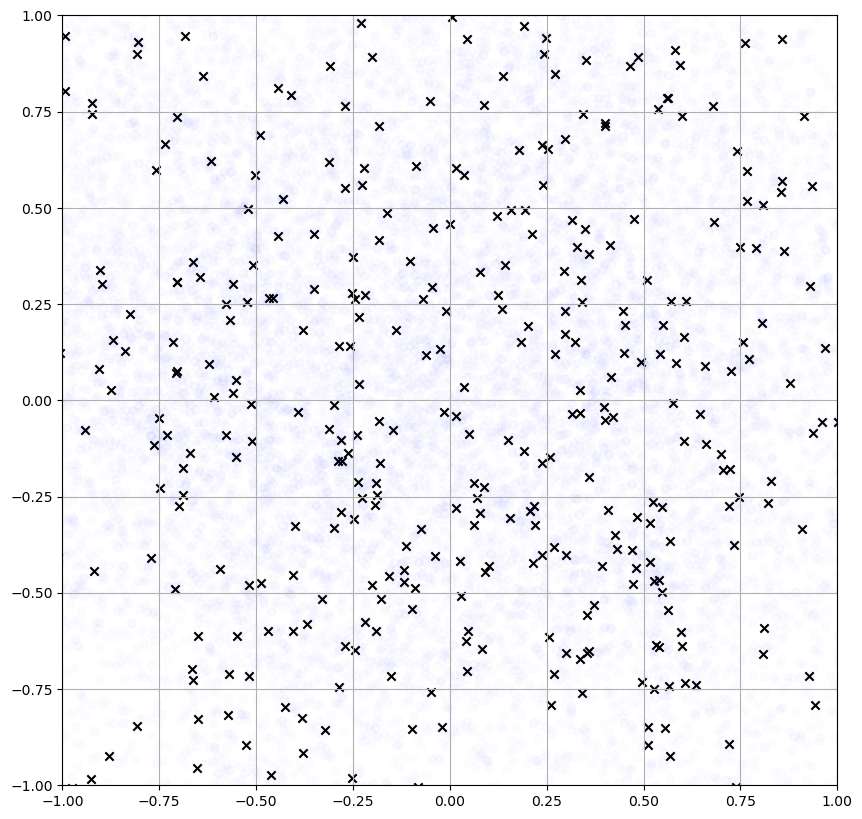

1
lse_loss -7.3646345138549805
commit_loss 0.6403641700744629
recon_loss 0.10096335411071777
2
lse_loss -7.492623329162598
commit_loss 0.6296834945678711
recon_loss 0.092072032392025
3
lse_loss -7.664664268493652
commit_loss 0.6178402304649353
recon_loss 0.08957904577255249
4
lse_loss -7.730381965637207
commit_loss 0.6068220138549805
recon_loss 0.09072291851043701
5
lse_loss -7.812029838562012
commit_loss 0.5936987400054932
recon_loss 0.08671882003545761
6
lse_loss -7.985964775085449
commit_loss 0.5769434571266174
recon_loss 0.08367598056793213
7
lse_loss -8.055769920349121
commit_loss 0.5605645179748535
recon_loss 0.08060827851295471
8
lse_loss -7.963068962097168
commit_loss 0.5502663850784302
recon_loss 0.08204518258571625
9
lse_loss -8.150267601013184
commit_loss 0.5276132225990295
recon_loss 0.07990488409996033
10
lse_loss -8.287108421325684
commit_loss 0.5166139006614685
recon_loss 0.07706832140684128
11
lse_loss -8.074135780334473
commit_loss 0.50895094871521
recon_loss 0.0708122

90
lse_loss -8.102618217468262
commit_loss 0.3883270025253296
recon_loss 0.02673681639134884
91
lse_loss -8.073180198669434
commit_loss 0.38651710748672485
recon_loss 0.027750685811042786
92
lse_loss -8.110548973083496
commit_loss 0.38914039731025696
recon_loss 0.024093598127365112
93
lse_loss -8.126770973205566
commit_loss 0.3843276798725128
recon_loss 0.0257978867739439
94
lse_loss -8.072907447814941
commit_loss 0.3831515908241272
recon_loss 0.025156483054161072
95
lse_loss -8.249722480773926
commit_loss 0.38299888372421265
recon_loss 0.0244598425924778
96
lse_loss -7.940821647644043
commit_loss 0.38602346181869507
recon_loss 0.025052275508642197
97
lse_loss -8.213471412658691
commit_loss 0.38636794686317444
recon_loss 0.022179465740919113
98
lse_loss -8.018115043640137
commit_loss 0.38530850410461426
recon_loss 0.023508936166763306
99
lse_loss -8.2421293258667
commit_loss 0.38720443844795227
recon_loss 0.02288045361638069
100
lse_loss -8.093171119689941
commit_loss 0.384859979152679

177
lse_loss -8.211539268493652
commit_loss 0.37315425276756287
recon_loss 0.01329532079398632
178
lse_loss -8.228899955749512
commit_loss 0.3729289174079895
recon_loss 0.014052540063858032
179
lse_loss -8.406973838806152
commit_loss 0.3710181713104248
recon_loss 0.014116112142801285
180
lse_loss -8.293469429016113
commit_loss 0.36620956659317017
recon_loss 0.014669058844447136
181
lse_loss -8.37981128692627
commit_loss 0.3692868947982788
recon_loss 0.013243730179965496
182
lse_loss -8.286004066467285
commit_loss 0.3719373345375061
recon_loss 0.01268208958208561
183
lse_loss -8.366888999938965
commit_loss 0.37169119715690613
recon_loss 0.012690586969256401
184
lse_loss -8.358431816101074
commit_loss 0.3685635030269623
recon_loss 0.013449977152049541
185
lse_loss -8.350924491882324
commit_loss 0.36531805992126465
recon_loss 0.014288387261331081
186
lse_loss -8.281420707702637
commit_loss 0.37110090255737305
recon_loss 0.01224079541862011
187
lse_loss -8.27934741973877
commit_loss 0.3673

lse_loss -8.394537925720215
commit_loss 0.3605012893676758
recon_loss 0.009531145915389061
265
lse_loss -8.403573036193848
commit_loss 0.35552990436553955
recon_loss 0.009828558191657066
266
lse_loss -8.3252592086792
commit_loss 0.3612689971923828
recon_loss 0.009496750310063362
267
lse_loss -8.465044975280762
commit_loss 0.3597174286842346
recon_loss 0.008905468508601189
268
lse_loss -8.459689140319824
commit_loss 0.3564838171005249
recon_loss 0.009303003549575806
269
lse_loss -8.373320579528809
commit_loss 0.35582369565963745
recon_loss 0.010517979972064495
270
lse_loss -8.524947166442871
commit_loss 0.3600912094116211
recon_loss 0.0093618119135499
271
lse_loss -8.666916847229004
commit_loss 0.35884976387023926
recon_loss 0.010064467787742615
272
lse_loss -8.419337272644043
commit_loss 0.3608700633049011
recon_loss 0.008801603689789772
273
lse_loss -8.449732780456543
commit_loss 0.3624027967453003
recon_loss 0.00834102276712656
274
lse_loss -8.495150566101074
commit_loss 0.3586920797

351
lse_loss -8.571440696716309
commit_loss 0.3509785532951355
recon_loss 0.007121347822248936
352
lse_loss -8.572531700134277
commit_loss 0.34697696566581726
recon_loss 0.0077271005138754845
353
lse_loss -8.58332347869873
commit_loss 0.3483569622039795
recon_loss 0.006971969269216061
354
lse_loss -8.644782066345215
commit_loss 0.3462921679019928
recon_loss 0.007381183095276356
355
lse_loss -8.649821281433105
commit_loss 0.34828633069992065
recon_loss 0.008096497505903244
356
lse_loss -8.705479621887207
commit_loss 0.34599512815475464
recon_loss 0.007855742238461971
357
lse_loss -8.619420051574707
commit_loss 0.3502647280693054
recon_loss 0.008488645777106285
358
lse_loss -8.659697532653809
commit_loss 0.3488667607307434
recon_loss 0.007773146033287048
359
lse_loss -8.592963218688965
commit_loss 0.34953030943870544
recon_loss 0.007629619911313057
360
lse_loss -8.73085880279541
commit_loss 0.3498954772949219
recon_loss 0.007597391959279776
361
lse_loss -8.646601676940918
commit_loss 0.3

438
lse_loss -8.751921653747559
commit_loss 0.34167084097862244
recon_loss 0.00701531395316124
439
lse_loss -8.77051067352295
commit_loss 0.3427201211452484
recon_loss 0.006877570413053036
440
lse_loss -8.907343864440918
commit_loss 0.34374284744262695
recon_loss 0.007491787429898977
441
lse_loss -8.788874626159668
commit_loss 0.3444652557373047
recon_loss 0.006052106618881226
442
lse_loss -8.739581108093262
commit_loss 0.34243243932724
recon_loss 0.0071341004222631454
443
lse_loss -8.846026420593262
commit_loss 0.3398541808128357
recon_loss 0.00728731881827116
444
lse_loss -8.83988094329834
commit_loss 0.34130242466926575
recon_loss 0.006452137138694525
445
lse_loss -8.88107967376709
commit_loss 0.3389277756214142
recon_loss 0.006017071194946766
446
lse_loss -8.850905418395996
commit_loss 0.34023481607437134
recon_loss 0.006741446442902088
447
lse_loss -8.765131950378418
commit_loss 0.34324365854263306
recon_loss 0.006445990409702063
448
lse_loss -8.810622215270996
commit_loss 0.33971

525
lse_loss -9.045371055603027
commit_loss 0.33293578028678894
recon_loss 0.007263398729264736
526
lse_loss -8.981131553649902
commit_loss 0.33591943979263306
recon_loss 0.006141230463981628
527
lse_loss -9.04055118560791
commit_loss 0.3317761719226837
recon_loss 0.006704976316541433
528
lse_loss -8.957585334777832
commit_loss 0.3363177180290222
recon_loss 0.006432108581066132
529
lse_loss -8.965132713317871
commit_loss 0.33576852083206177
recon_loss 0.006683933548629284
530
lse_loss -9.10334300994873
commit_loss 0.337499737739563
recon_loss 0.006587057374417782
531
lse_loss -9.000174522399902
commit_loss 0.3373410403728485
recon_loss 0.00695180706679821
532
lse_loss -8.878436088562012
commit_loss 0.3369358479976654
recon_loss 0.005711057689040899
533
lse_loss -9.007323265075684
commit_loss 0.33585864305496216
recon_loss 0.00646064430475235
534
lse_loss -8.925448417663574
commit_loss 0.3336551785469055
recon_loss 0.006549320183694363
535
lse_loss -8.932454109191895
commit_loss 0.33396

lse_loss -9.077685356140137
commit_loss 0.33591678738594055
recon_loss 0.00550895556807518
613
lse_loss -9.16698932647705
commit_loss 0.3314496576786041
recon_loss 0.006374357268214226
614
lse_loss -9.267916679382324
commit_loss 0.32664746046066284
recon_loss 0.005472231190651655
615
lse_loss -9.304362297058105
commit_loss 0.3312697112560272
recon_loss 0.0051992544904351234
616
lse_loss -9.279475212097168
commit_loss 0.3296682834625244
recon_loss 0.005740602500736713
617
lse_loss -9.280573844909668
commit_loss 0.3288794755935669
recon_loss 0.005422394257038832
618
lse_loss -9.218131065368652
commit_loss 0.32994475960731506
recon_loss 0.0051463451236486435
619
lse_loss -9.19440746307373
commit_loss 0.3352736830711365
recon_loss 0.00615629181265831
620
lse_loss -9.180033683776855
commit_loss 0.33193808794021606
recon_loss 0.0054051317274570465
621
lse_loss -9.177817344665527
commit_loss 0.33272799849510193
recon_loss 0.005688452161848545
622


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1, quant_temp='rand')

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-7
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.grid()
plt.show() 